 # <u><center>Algorithme de détection automatique de faux billets</center></u>

## Sommaire :
 **Partie 1 : Introduction**
 - <a href="#C1">Contexte</a>
 
**Partie 2 : Paramétrage de l'algorithme**
 - <a href="#C2">2.1 Import et nettoyage des données</a>
 - <a href="#C3">2.2 Tests de différents modèles</a>
 
**Partie 3 : Mise en production**
 - <a href="#C4">3.1 Choix du modèle final</a>
 - <a href="#C5">3.2 Tests de billets</a>

# <u> Partie 1 : Introduction</u>

## <a name="C1"><u>Contexte</u></a>
L’Organisation nationale de lutte contre le faux-monnayage (ONCFM), est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, elle souhaite mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets. <br><br>
L'organisme met à disposition un fichier de 1500 billets étiquetés : 1000 'vrais' billets et 500 'faux' billets. Les billets sont caractérisés par des dimensions géométriques précises :
- length : la longueur du billet (en mm) ; 
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ; 
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ; 
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ; 
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ; 
- diagonal : la diagonale du billet (en mm).

Il s'agit ici d'un problème de classification qui sera résolu à l'aide du machine learning supervisé et non supervisé. Sur le principe, plusieurs modèles seront testés afin de choisir le plus pertinent pour cette problématique.

# <u> Partie 2 : Paramétrage de l'algorithme</u>

#### Import des librairies

In [1]:
import warnings # suppression des warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
# Matplotlib & Seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# Plotly for additional plotting
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white" # Application d'un thème par défaut
# Statmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Scipy
from scipy import stats
from scipy.stats import t, shapiro

In [2]:
# Sklearn Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
# Pre-processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
# Models selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV #Cross validation
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #Evaluation des modèles
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## <a name="C2"><u>2.1 Import et nettoyage des données</u></a>

### 2.1.1 Analyse du fichier de paramétrisation
Import du fichier contenant les caractéristiques et classification des 1500 billets. 

In [3]:
data = pd.read_csv('billets.csv', sep=";")
display(data.head())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Le fichier est assez propre ; toutes les colonnes comportent à priori le type de données adéquats. Etant donné qu'il y a des valeurs manquantes dans la colonne 'margin_low', nous allons les remplacer en fonction des autres variables à l'aide d'une régression linéaire.

In [5]:
display(data.isna().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Vérification des doublons :

In [6]:
display(data.duplicated().sum())

0

Quelques statistiques :

In [7]:
display(data.describe())

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


La table ne contient pas à priori de valeurs aberrantes.

Nombre de vrais/faux billets : 

In [8]:
display(data['is_genuine'].value_counts())

True     1000
False     500
Name: is_genuine, dtype: int64

Les valeurs de la colonne 'is_genuine' sont remplacées : 
- False = 0 
- True = 1 

In [9]:
# Conversion du type de la colonne et remplacement des valeurs
data['is_genuine'] = data['is_genuine'].astype(str)
data['is_genuine'].replace(['False','True'],[0,1], regex=True, inplace=True)
data['is_genuine'] = data['is_genuine'].astype(int)

In [10]:
display(data.head())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


#### Aperçu des corrélations et distributions 

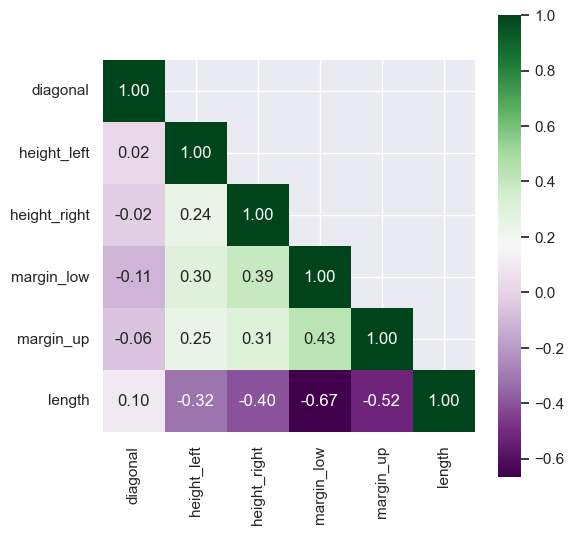

In [11]:
#correlation matrix
corrmat = data.drop('is_genuine', axis=1).corr()
# On crée un mask pour n'afficher que la partie en dessous de la diagonale
mask = np.triu(np.ones_like(corrmat, dtype=bool))
# On affiche la diagonale
np.fill_diagonal(mask, False)

plt.figure(figsize=(6,6))
sns.heatmap(corrmat, annot=True, cmap='PRGn', mask=mask, square=True,fmt='.2f');

Les variables sont faiblement corrélées entre elles, à l'exception des variables `length` et `margin_low` qui ont une corrélation assez élevée. Les corrélations entre les variable selon la catégorie des billets est mise en évidence dans le graphique ci-dessous.

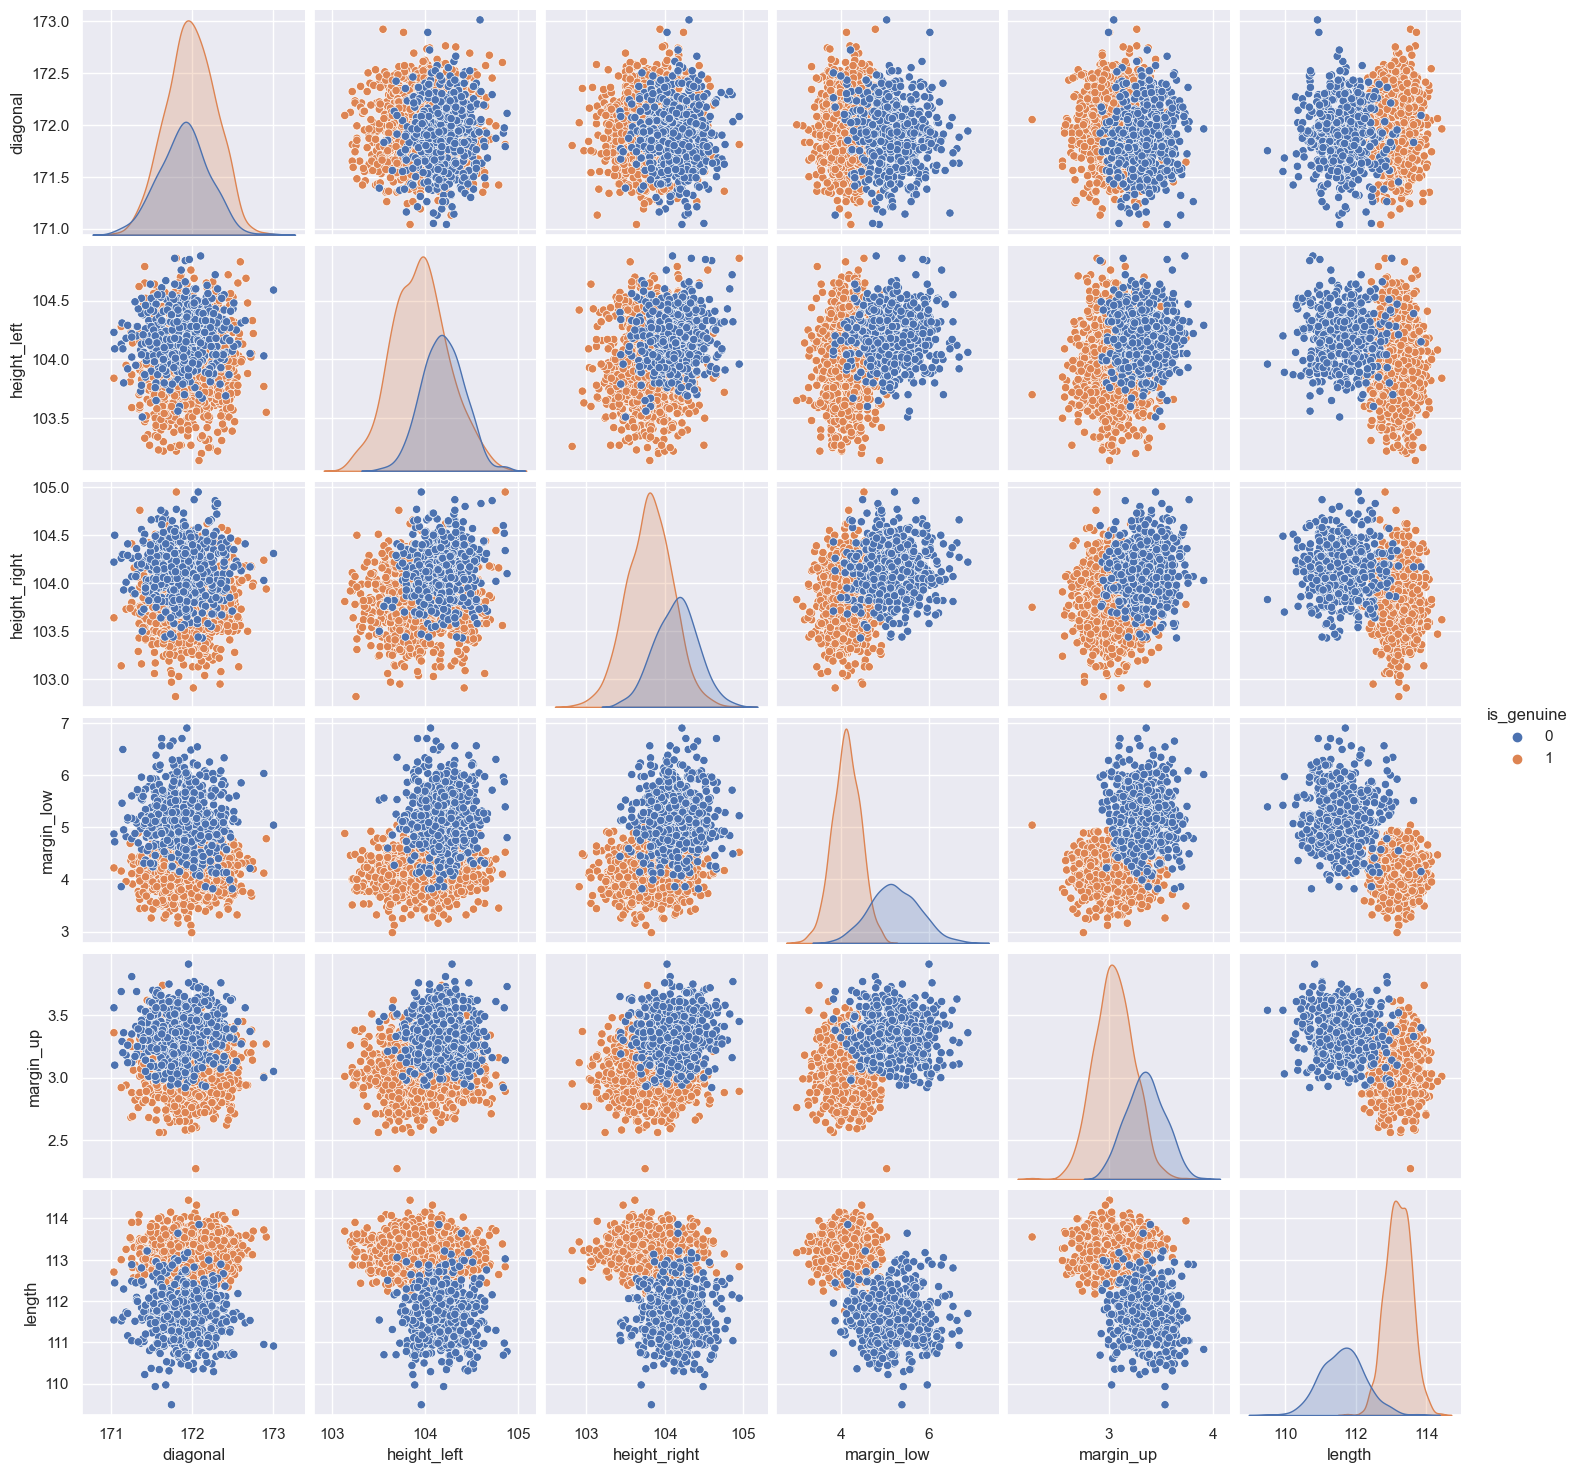

In [12]:
sns.pairplot(data, hue='is_genuine')
plt.savefig('distributions_variables.png')

### 2.1.2 Regression linéaire multiple
Les valeurs manquantes de la colonne `margin_low` sont remplacées par régression linéaire.

In [13]:
# Données ne contenant pas la colonne 'is_genuine' ni les données manquantes:
data_num = data.drop('is_genuine', axis=1)
# Stocakge des valeurs nulles dans un df
data_null = data_num.loc[data_num['margin_low'].isnull()]
# Suppression des valeurs nulles du df qui servira pour l'analyse
data_num.dropna(axis=0, inplace=True)

Résultats du modèle : 

In [14]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=data_num).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          2.60e-202
Time:                        23:21:13   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Les paramètres sont significativement différents de 0, car leur p-valeur est inférieure à 5 %, le niveau de test souhaité.

Le $R^{2}$ vaut environ 0.48, et le $R^{2}$ ajusté est d'environ 0.48. Ceci traduit néanmoins une corrélation qui n'est ni faible, ni forte.

### 2.1.3  Analyse du modèle de régression
Il est intéressant d'effectuer une analyse du modèle pour évaluer sa performance. Les tests sont réalisés à un niveau $\alpha=5$%. <br>
Dans un premier temps, il faut extraire le nombre d'individus de l'échantillon $n$ et le nombre de variables $p$ .

In [15]:
# Seuil de tolérance
alpha = 0.05
# Nombre d'occurrences
n = data_num.shape[0]
# Nombre de prédicteurs
p = len(data_num.columns)

Dans un second temps, les analyses sur les valeurs atypiques et/ou influentes sont faites à l'aide d'un dataframe appelé analyses.

In [16]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
display(analyses)

,obs
0,1
1,2
2,3
3,4
4,5
...,...
1458,1459
1459,1460
1460,1461
1461,1462


### Détermination des valeurs atypiques
#### Calcul des les leviers
Les leviers sont calculés comme suit, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [17]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

Ci-dessous les observations atypiques vis-à-vis des variables explicatives :

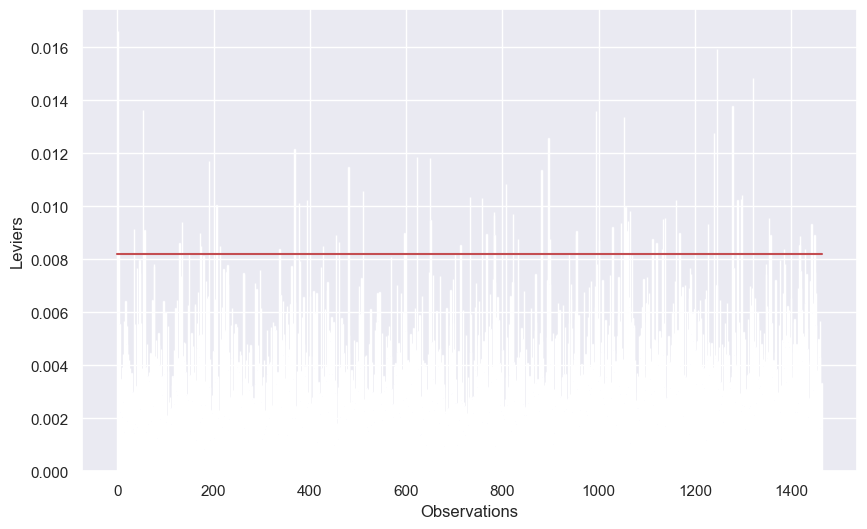

In [18]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'], color='blue')
# plt.xticks(np.arange(0, n, step=5))
plt.xlabel('Observations')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.show()

Il y a quelques valeurs qui dépassent le seuil limite. Il faut compléter l'analyse avant de conclure.

#### Calcul des résidus studentisés
Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [19]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2, n-p-1)

Ci-dessous les observations atypiques vis-à-vis de la variable à expliquer ('margin_low') :

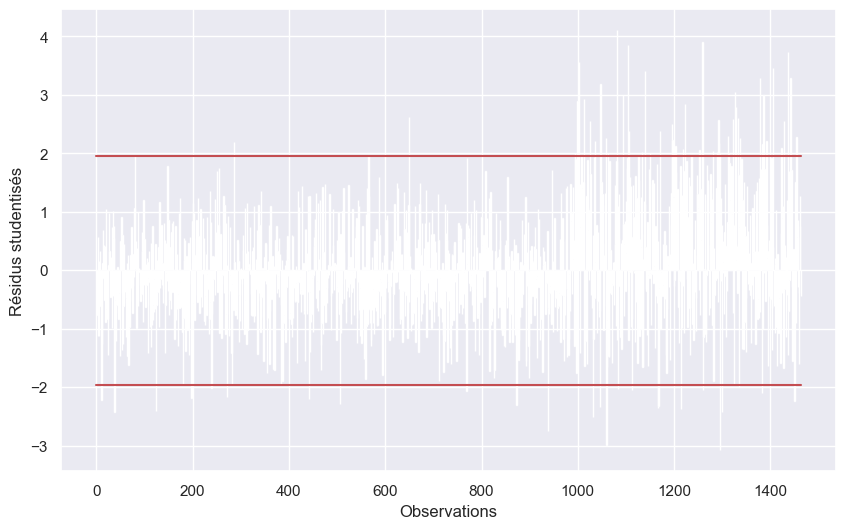

In [20]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
# plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observations')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

Des valeurs dépassent le seuil limite ; il faut également vérifier si elle sont influentes.

### Détermination des valeurs influentes
#### Déterminez la distance de Cook
Le seuil de la distance de Cook est de n-p.

In [21]:
influence = reg_multi.get_influence().summary_frame()

In [22]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

Ci-dessous les observations influentes :

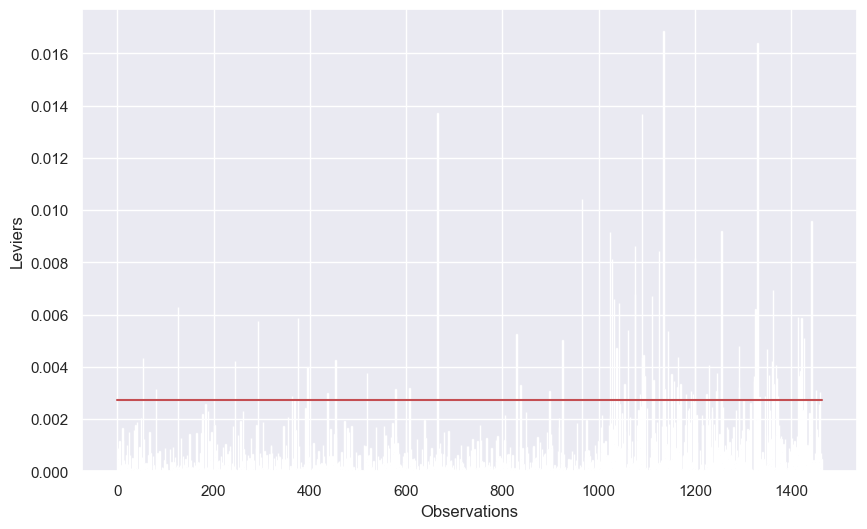

In [23]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
# plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observations')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.show()

Des valeurs dépassent le seuil limite. Ci dessous, sont mises en évidence celles qui sont **influentes et atypiques** : 

In [24]:
data_influ_at = analyses.loc[(analyses['levier'] > seuil_levier) & (analyses['rstudent'] > seuil_rstudent) &
                           (analyses['dcooks'] > seuil_dcook), :]
print("Nombre d'observations influentes et atypiques : ",data_influ_at.shape[0])
print("Pourcentage d'observations influentes et atypiques :",np.round(100*data_influ_at.shape[0]/n),'%')
display(data_influ_at)

Nombre d'observations influentes et atypiques :  1
Pourcentage d'observations influentes et atypiques : 0.0 %


,obs,levier,rstudent,dcooks
1441,1442,0.009325,3.280337,0.009596


Ces valeurs atypiques et influentes seront supprimées.

In [25]:
# Stocakge dans une liste des indexes des valeurs à supprimer
index_supp = data_influ_at.index.tolist()

#### Vérification de la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [26]:
variables = reg_multi.model.exog
display([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])])

[1.0136128990686282,
 1.1382605736082487,
 1.230114515556039,
 1.4044037781843626,
 1.5769501453665813]

Ici, tous les coefficients d'influence de la variance sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Vérification de l’homoscédasticité
L’homoscédasticité (c'est-à-dire la constance de la variance) des résidus est testée :

In [27]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216191284e-16


#### Test de normalité des réisdus
La noramlité est testée via le test de Shapiro-Wilk.

In [28]:
display(shapiro(reg_multi.resid))

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

Distribution des résidus :

<Axes: >

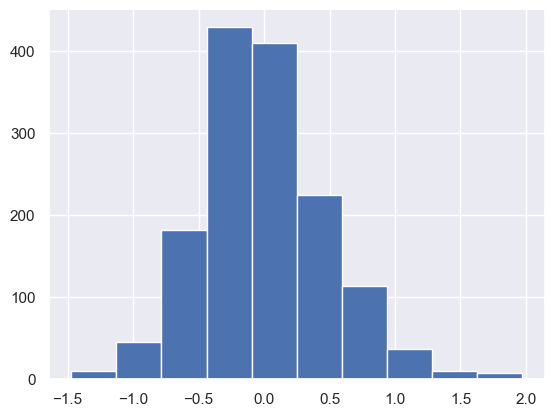

In [29]:
display(reg_multi.resid.hist())

Les hypothèses de normalité et d'homoscédasticité sont remises en cause (p-value < 0.05).


Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30), le modèle linéaire sera "considéré" comme gaussien.

#### Prédiction des valeurs manquantes
Les valeurs atypiques et influentes sont au préalable supprimées pour qu'elles ne puissent pas influencer la prédiction.

In [30]:
# Suppression des valeurs atypiques et influentes
data_num.drop(data_num.index[index_supp], inplace=True)

Avant de procéder à la prédiction, il faut concatener le dataframe contenant les valeurs nulles `margin_low` avec celui contenant les données dans lesquelles les valeurs atypiques et influentes ont été supprimées.

In [31]:
# Concatenation des deux dataframes
data_num_test = pd.concat([data_num, data_null])
data_num_test.reset_index(inplace=True)

In [32]:
# Jointure pour récupérer la colonne "is_genuine"
data_num_total = (data_num_test.loc[:,['index']]).merge(
    data.reset_index(),
    on='index',
    indicator=True
)
data_num_total.head()

,index,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,_merge
0,0,1,171.81,104.86,104.95,4.52,2.89,112.83,both
1,1,1,171.46,103.36,103.66,3.77,2.99,113.09,both
2,2,1,172.69,104.48,103.50,4.40,2.94,113.16,both
3,3,1,171.36,103.91,103.94,3.62,3.01,113.51,both
4,4,1,171.73,104.28,103.46,4.04,3.48,112.54,both


La vérification de la jointure est faite : tous les indexes se trouvent des deux côtés.

In [33]:
display(data_num_total['_merge'].value_counts())

both          1499
left_only        0
right_only       0
Name: _merge, dtype: int64

In [34]:
# Suppression de la colonne de vérification
data_num_total.drop('_merge', axis=1, inplace=True)

In [35]:
# Reformatage du dataset
data_num_total.sort_values('index', inplace=True)
data_num_total.set_index('index', inplace=True)
data_num_total.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
index,,,,,,,
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [36]:
# Réaffectation du dataframe
data_num = data_num_total.copy()
# Suppression des valeurs nulles pour la prédiction
data_num.dropna(axis=0, inplace=True)
del(data_num_total)

Les valeurs manquantes sont prédites à partir des autres colonnes.

In [37]:
# Prédicteurs
X = data_num.drop(['is_genuine','margin_low'], axis=1)
# Variable à prédire
y = data_num['margin_low']

In [38]:
# Standardisation des prédicteurs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Train test et split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0)

In [40]:
# On instancie le modèle dans un estimateur 
lin_reg = LinearRegression()
# On fit
display(lin_reg.fit(X_train, y_train))

LinearRegression()

Les valeurs sont ensuite prédites : 

In [41]:
y_pred_lr = lin_reg.predict(X_test)

Mean Square Error : 

In [42]:
mse_linereg = mean_squared_error(y_test,y_pred_lr)
display(mse_linereg)

0.23204249121195164

Calcul du score du train et du test :

In [43]:
def score(estimator):
    """Calcule et affiche les scores du train et test"""
    
    tr_score = estimator.score(X_train, y_train).round(4) #train score
    te_score = estimator.score(X_test, y_test).round(4) #test score
    
    print(f"train score : {tr_score} / test score : {te_score}")

In [44]:
score(lin_reg)

train score : 0.4851 / test score : 0.4493


Le test score est légèrement inférieur au train score : le modèle est en situation d'overfitting. Nous décidons de régulariser le modèle pour augmenter son biais et diminuer sa variance. 

### Ridge regression
Au vu du nombre de variables et d'occurrences, la ridge regression semble adaptée pour régulariser le modèle.

In [45]:
# Train test et split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0)

In [46]:
# On instancie le modèle dans un estimateur et on fit
ridge_reg = Ridge()
display(ridge_reg.fit(X_train, y_train))

Ridge()

Pour optimiser le modèle, plusieurs valeurs du paramètre L2 sont testées : 

In [47]:
grid = GridSearchCV(
    estimator=ridge_reg,
    param_grid={'alpha' : np.logspace(-2,2,50)},
    scoring='neg_mean_squared_error',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y);

Le Mean Square Error est inférieur à celui du modèle de base, ce qui est intéressant : 

In [48]:
mse_ridgereg = abs(grid.best_score_)
display(mse_ridgereg)

0.235399495935633

La valeur optimale de L2 est ainsi obtenue : 

In [49]:
display(grid.best_params_)

{'alpha': 4.941713361323833}

In [50]:
ridge_reg = Ridge(alpha=grid.best_params_['alpha'])
display(ridge_reg.fit(X_train, y_train))

Ridge(alpha=4.941713361323833)

In [51]:
score(ridge_reg)

train score : 0.4851 / test score : 0.4492


Il s'avère que la régularisation avec la regression ridge n'est pas très pertinente étant donné que les scores des modèles ne sont quasiment pas différents. Néanmoins, la ridge regression est retenue fait d'un MSE plus faible.

### Remplacement des valeurs nulles 
Les valeurs nulles sont remplacées par régression linéaire ridge.

In [52]:
# DF contenant les prédicteurs (standardisés) des valeurs nulles de la colonne margin_low
predicteurs = data[data['margin_low'].isna()].drop(['is_genuine','margin_low'], axis=1)
predicteurs = scaler.fit_transform(predicteurs)

Valeurs prédites : 

In [53]:
margin_low_pred = ridge_reg.predict(predicteurs).round(2)
print(margin_low_pred.shape)
display(margin_low_pred)

(37,)


array([4.45, 4.49, 4.49, 4.47, 4.75, 3.93, 4.29, 4.22, 4.24, 4.27, 4.3 ,
       3.83, 4.14, 4.43, 4.25, 4.17, 4.54, 4.58, 4.45, 4.18, 3.71, 4.45,
       4.18, 4.37, 3.99, 3.83, 4.35, 4.8 , 4.24, 5.16, 4.92, 5.19, 5.16,
       4.9 , 5.89, 5.3 , 5.26])

Les valeurs manquantes sont ainsi remplacées : 

In [54]:
data.loc[data['margin_low'].isna(),'margin_low'] = margin_low_pred

In [55]:
# Vérification si il y a encore des valeurs nulles
display(data.isna().sum().sum())

0

D'après les statistiques sur la table, la colonne 'margin_low' a été bien remplie :

In [56]:
display(data.describe())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.486093,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659631,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.320000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## <a name="C3"><u>2.2 Tests de différents modèles</u></a>
Cette partie traite de l'implémentation des modèles de classification qui permettront de détecter les vrais et faux billets.

#### Préparation des données
Les données sont préparées en amont pour la réalisation des modèles.

In [57]:
# Prédicteurs
X = data.drop('is_genuine', axis=1)
# Variable à prédire
y = data['is_genuine']

In [58]:
# Standardisation des prédicteurs
X_scaled = scaler.fit_transform(X)

#### Train test split
Nous allons séparer nos données pour l'entraînement (80%) et le test (20%) : 

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0)

In [60]:
print("Nous avons un X_train de forme ",X_train.shape,"et un y_train de forme ", y_train.shape)
print("Nous avons un X_test de forme ",X_test.shape,"et un y_test de forme ", y_test.shape)

Nous avons un X_train de forme  (1200, 6) et un y_train de forme  (1200,)
Nous avons un X_test de forme  (300, 6) et un y_test de forme  (300,)


#### Matrice de confusion
Nous créons une fonction pour afficher la matrice de confusion : 

In [61]:
# Matrice de confusion
def confusion(y_test, y_pred):
    """Affiche la matrice de confusion"""
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat = pd.DataFrame(conf_mat)
    conf_mat.columns = [f"test_{i}" for i in conf_mat.columns]
    conf_mat.index = [f"pred_{i}" for i in conf_mat.index]
    
    return conf_mat

Nous créeons également une foction qui retourne les scores du train et du test.

In [62]:
def score(estimator):
    """Calcule et affiche les scores du train et test"""
    
    tr_score = estimator.score(X_train, y_train).round(4) #train score
    te_score = estimator.score(X_test, y_test).round(4) #test score
    
    print(f"train score : {tr_score} / test score : {te_score}")

### 2.2.1 Dummy classifier
Nous allons tout d'abord entraîner un classifieur naïf sur nos données pour avoir un aperçu du score de base pour notre étude.

In [63]:
# On instancie le modèle dans un estimateur
dum_clf = DummyClassifier(strategy='most_frequent', random_state=1)
# On fit
display(dum_clf.fit(X_train, y_train))

DummyClassifier(random_state=1, strategy='most_frequent')

In [64]:
# On fait une prédiction sur les données de test
y_pred_dc = dum_clf.predict(X_test)

On calcule ensuite les "accuracy scores" du train et test sets : 

In [65]:
score(dum_clf)

train score : 0.6642 / test score : 0.6767


Proportion dans le training set : 

In [66]:
display(pd.Series(y_train).value_counts(normalize=True).round(4))

1    0.6642
0    0.3358
Name: is_genuine, dtype: float64

Proportion dans le test set : 

In [67]:
display(pd.Series(y_test).value_counts(normalize=True).round(4))

1    0.6767
0    0.3233
Name: is_genuine, dtype: float64

Matrice de confusion : 

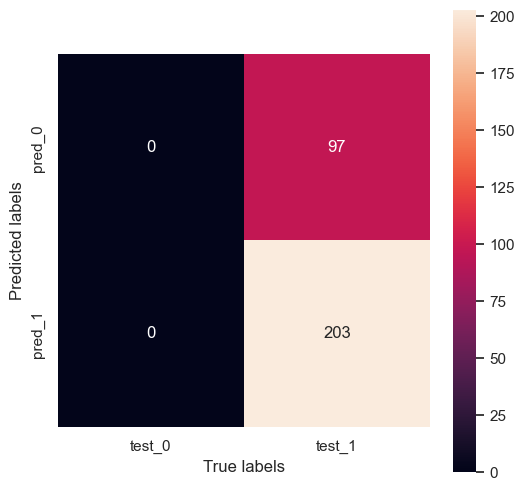

In [68]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(y_test, y_pred_dc), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

In [69]:
print(classification_report(y_test, y_pred_dc, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        97
           1      0.677     1.000     0.807       203

    accuracy                          0.677       300
   macro avg      0.338     0.500     0.404       300
weighted avg      0.458     0.677     0.546       300



Calcul de l'AUC score, c'est-à-dire l'aire en dessous de la courbe ROC (Receiver Operating Characteristic) : 

In [70]:
roc_auc_dc = roc_auc_score(y_test, y_pred_dc).round(4)
display(roc_auc_dc)

0.5

Ce modèle n'est pas du tout intéressant en raison de sa précision et AUC très faibles.

### 2.2.2 KNN
Entraînement d'un modèle K-Nearest-Neighbors pour la classification.

In [71]:
knn = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier())
])
display(knn.fit(X_train, y_train))

Pipeline(steps=[('scale', StandardScaler()), ('model', KNeighborsClassifier())])

In [72]:
y_pred_knn = knn.predict(X_test)

Matrice de confusion : 

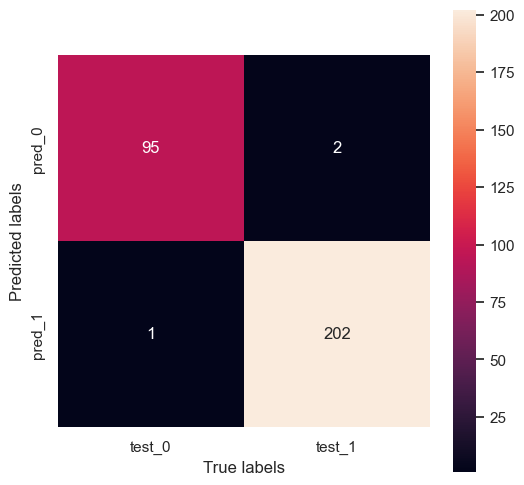

In [73]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(y_test, y_pred_knn), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

Sont obtenus 202 vrais positifs et 95 vrais négatifs, ce qui porte la précision du modèle à 99%.

In [74]:
score(knn)

train score : 0.9925 / test score : 0.99


Le test score est légèrement supérieur au train score.

In [75]:
print(classification_report(y_test, y_pred_knn, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.979     0.984        97
           1      0.990     0.995     0.993       203

    accuracy                          0.990       300
   macro avg      0.990     0.987     0.989       300
weighted avg      0.990     0.990     0.990       300



Calcul de l'AUC score, c'est-à-dire l'aire en dessous de la courbe ROC (Receiver Operating Characteristic) : 

In [76]:
roc_auc_knn = roc_auc_score(y_test, y_pred_knn).round(4)
display(roc_auc_knn)

0.9872

Le modèle a de bien meilleures perforamnces que le dummy classifier : la précision est de l'ordre de 99%.

### 2.2.3 Regression logistique
La régression logistique est une méthode de classification supervisée permettant d'expliquer une variable qualitative à plusiseurs modalités en fonction de variables quantitatives.


Le modèle est entraîné sur le jeu de données et les résultats sont aisni obtenus : 

In [77]:
reg_log2 = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=data, family=sm.families.Binomial()).fit()
print(reg_log2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1493
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.262
Date:                Thu, 01 Jun 2023   Deviance:                       86.525
Time:                        23:21:32   Pearson chi2:                 2.50e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7034
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -191.2144    238.240     -0.803   

Tous les paramètres sont significatifs à l'exception de `diagonal` et `height_left` ; ils seront néanmoins tous intégrés dans le modèle de prédiction.

In [78]:
# On instancie le modèle dans un estimateur
log_reg = LogisticRegression(solver='liblinear')
# On fit
display(log_reg.fit(X_train, y_train))

LogisticRegression(solver='liblinear')

In [79]:
y_pred_logr = log_reg.predict(X_test)

Matrice de confusion : 

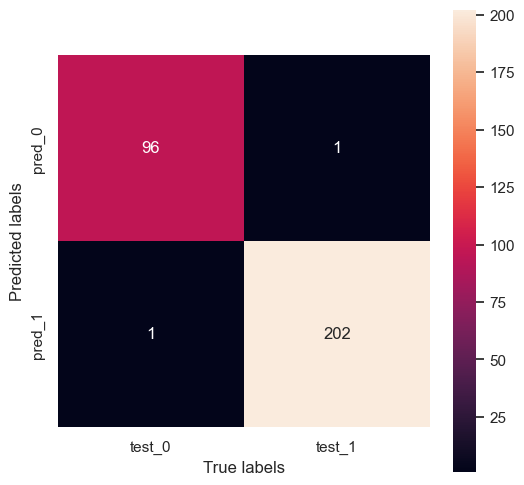

In [80]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(y_test, y_pred_logr), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

In [81]:
score(log_reg)

train score : 0.99 / test score : 0.9933


Le test score est supérieur au train score : le modèle généralise bien.

In [82]:
print(classification_report(y_test, y_pred_logr, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.990     0.990        97
           1      0.995     0.995     0.995       203

    accuracy                          0.993       300
   macro avg      0.992     0.992     0.992       300
weighted avg      0.993     0.993     0.993       300



Sont obtenus 202 vrais positifs et 96 vrais négatifs, ce qui porte la précision du modèle à 99%.

#### Optimisation des hyperparamètres

Une tentative d'optimisation des hyperparamètres (C, l1-l2) est faite en vue d'augmenter les performances du modèle.

In [83]:
grid = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={'C':np.logspace(-3,3,10),
                'penalty':['l1','l2'],
               },
    return_train_score=True,
    cv=10,
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Les meilleurs paramètres sont ainsi obtenus : 

In [84]:
display(grid.best_params_)

{'C': 2.154434690031882, 'penalty': 'l2'}

Les résultats détaillés sont les suivants : 

In [85]:
def result_grid(grid):
    """Affichage de l'ensemble des résultats du grid search"""
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('mean_test_score', ascending=False)
    
    return res

In [86]:
display(result_grid(grid).head(5))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
19,0.003518,0.002785,0.001001,0.002226,1000.0,l2,"{'C': 1000.0, 'penalty': 'l2'}",0.989333,0.005333,1,0.990074,0.000363
17,0.006267,0.001761,0.000917,0.001582,215.443469,l2,"{'C': 215.44346900318823, 'penalty': 'l2'}",0.989333,0.005333,1,0.990074,0.000363
15,0.003579,0.003295,0.001601,0.003202,46.415888,l2,"{'C': 46.41588833612773, 'penalty': 'l2'}",0.989333,0.005333,1,0.990000,0.000497
13,0.004841,0.002715,0.001852,0.002722,10.0,l2,"{'C': 10.0, 'penalty': 'l2'}",0.989333,0.005333,1,0.989852,0.000474
11,0.004271,0.003905,0.001113,0.001973,2.154435,l2,"{'C': 2.154434690031882, 'penalty': 'l2'}",0.989333,0.005333,1,0.989481,0.000864


In [87]:
best_params=grid.best_params_

In [88]:
# On instancie la régression logistique avec les meilleurs paramètres
log_reg = LogisticRegression(**best_params)
display(log_reg.fit(X_train, y_train))

LogisticRegression(C=2.154434690031882)

In [89]:
y_pred_logr = log_reg.predict(X_test)

La matrice de confusion est identique : 

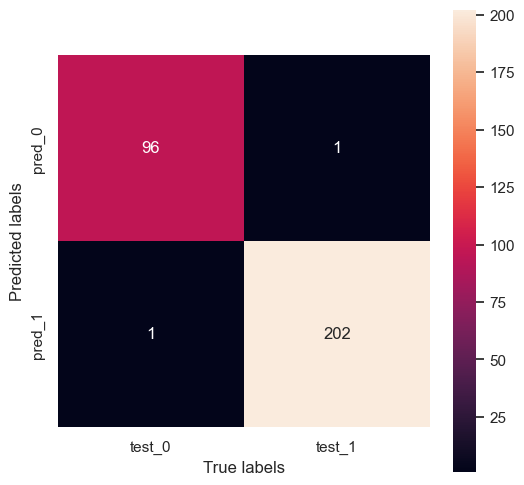

In [90]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(y_test, y_pred_logr), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

In [91]:
score(log_reg)

train score : 0.9908 / test score : 0.9933


Le test score est supérieur au train score : le modèle généralise bien.

In [92]:
print(classification_report(y_test, y_pred_logr, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.990     0.990        97
           1      0.995     0.995     0.995       203

    accuracy                          0.993       300
   macro avg      0.992     0.992     0.992       300
weighted avg      0.993     0.993     0.993       300



Calcul de l'AUC score, c'est-à-dire l'aire en dessous de la courbe ROC (Receiver Operating Characteristic) : 

In [93]:
roc_auc_logr = roc_auc_score(y_test, y_pred_logr).round(4)
display(roc_auc_logr)

0.9924

Du fait du jeu de données assez simple, le modèle est difficilement optimisable. La régression logistique sera le modèle retenu car il est optimisé avec les meilleurs paramètres.

### 2.2.4 SVM Classifier
Entraînement d'un modèle de classification SVM. 

In [94]:
svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("model", LinearSVC(loss="hinge")),
    ))
display(svm_clf.fit(X_train, y_train))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(loss='hinge'))])

In [95]:
y_pred_svc = svm_clf.predict(X_test)

Matrice de confusion : 

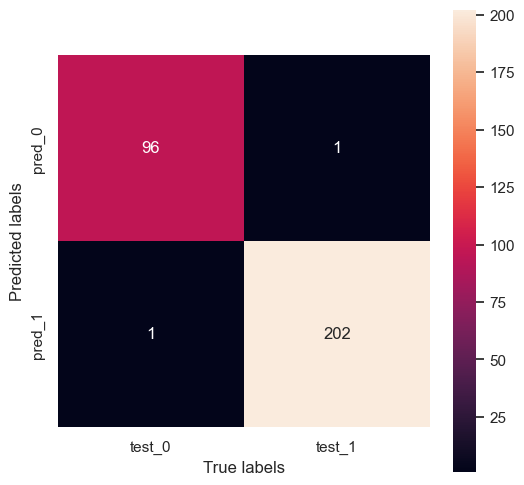

In [96]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(y_test, y_pred_svc), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

In [97]:
score(svm_clf)

train score : 0.9917 / test score : 0.9933


Le test score est supérieur au train score : le modèle généralise bien.

In [98]:
print(classification_report(y_test, y_pred_svc, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.990     0.990        97
           1      0.995     0.995     0.995       203

    accuracy                          0.993       300
   macro avg      0.992     0.992     0.992       300
weighted avg      0.993     0.993     0.993       300



Calcul de l'AUC score, c'est-à-dire l'aire en dessous de la courbe ROC (Receiver Operating Characteristic) : 

In [99]:
roc_auc_svc = roc_auc_score(y_test, y_pred_svc).round(4)
display(roc_auc_svc)

0.9924

Les résultats sont indentiques à la régression logistique.

### 2.2.5 Random Forests classifier
Entraînement d'un modèle de forêts aléatoires pour la classification.

In [100]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)
display(rnd_clf.fit(X_train, y_train))

RandomForestClassifier(max_leaf_nodes=10, n_jobs=-1)

In [101]:
y_pred_rfc = rnd_clf.predict(X_test)

Matrice de confusion : 

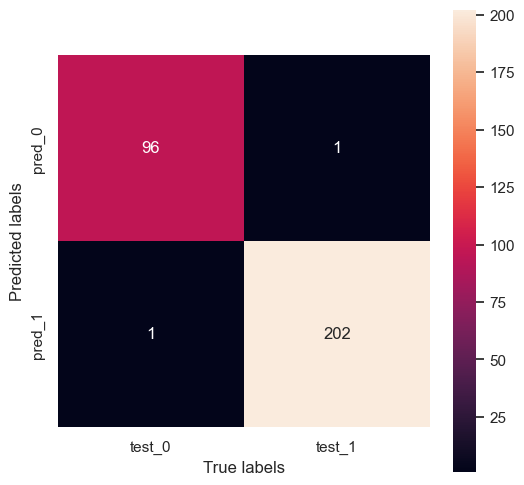

In [102]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(y_test, y_pred_rfc), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

In [103]:
score(rnd_clf)

train score : 0.9925 / test score : 0.9933


Sont obtenus 201 vrais positifs et 96 vrais négatifs, ce qui porte la précision du modèle à 99%.

In [104]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        97
           1       1.00      1.00      1.00       203

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Calcul de l'AUC score, c'est-à-dire l'aire en dessous de la courbe ROC (Receiver Operating Characteristic) : 

In [105]:
roc_auc_rfc = roc_auc_score(y_test, y_pred_rfc).round(4)
display(roc_auc_rfc)

0.9924

Le test score est légèrement supérieur au train score. On ne peut pas dire qu'il y a overfitting. Par ailleurs les résultats sont indentiques à la régression logistique et au SVC.

### 2.2.6 K-means
Entraînement d'un modèle de classification non supervisé : le K-means. Le nombre de cas est égal à 2, étant donné qu'on a deux classes (vrai ou faux).

In [106]:
# Vecteur cible
target = data['is_genuine'].values

In [107]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [108]:
# On fit le modèle
kmeans = KMeans(n_clusters=2, random_state=8)
display(kmeans.fit(X_scaled))

KMeans(n_clusters=2, random_state=8)

Les valeurs prédites par le K-means sont les deux clusters :

In [109]:
# Clusters obtenus
clusters = kmeans.labels_
display(clusters)

array([1, 0, 0, ..., 1, 1, 1])

Affectation des valeurs 0 à faux billet et 1 à vrai billet.

In [110]:
clusters = clusters+1
clusters[clusters == 2] = 0

Les centroïdes sont également obtenus : 

In [111]:
centroids = kmeans.cluster_centers_

Matrice de confusion : 

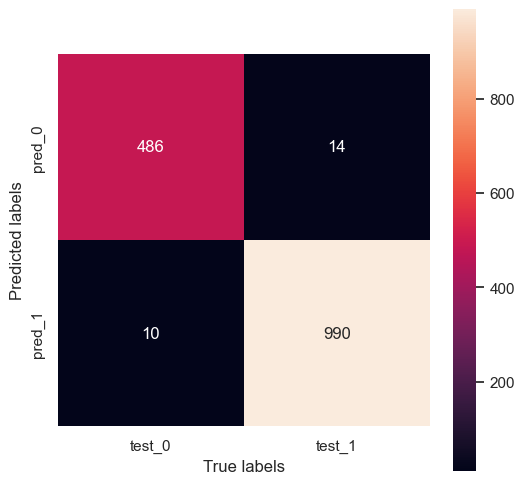

In [112]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion(target, clusters), annot=True, fmt='.0f', square=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Evaluation du modèle : 

In [113]:
print(classification_report(target, clusters, digits=3))

              precision    recall  f1-score   support

           0      0.980     0.972     0.976       500
           1      0.986     0.990     0.988      1000

    accuracy                          0.984      1500
   macro avg      0.983     0.981     0.982      1500
weighted avg      0.984     0.984     0.984      1500



Calcul de l'AUC score, c'est-à-dire l'aire en dessous de la courbe ROC (Receiver Operating Characteristic) : 

In [114]:
roc_auc_kmeans = roc_auc_score(target, clusters).round(4)
display(roc_auc_kmeans)

0.981

Sont obtenus 990 vrais positifs et 486 vrais négatifs, ce qui porte la précision du modèle à 98%.
Le modèle est assez performant car il a correctement étiqueter 98% des données.

# <u> Partie 3 : Mise en production</u>
Cette partie concerne le test en conditions réelles de l'algorithme.

## <a name="C4"><u>3.1 Choix du modèle final</u></a>
Le modèle final retenu est la regression logistique pour plusieurs raisons : 
- Hyperparamètres optimisés
- Précision supérieure à 99%
- AUC la plus élevée et très proche de 1 (0.9924)
---
Néanmoins, il est important de notre qu'ici, le jeu de données est très sain (aucune valeur aberrante, valeurs nulles facilement imputables par une régression). Les modèles entraînés sont performants pour réaliser la tâche de détection de faux billets.

## <a name="C5"><u>3.2 Tests de billets</u></a>
Pour la mise en production, nous avons opté pour une fonction qui récupère le fichier csv à analyser et retourne un fichier csv avec une colonne supplémentaire `prediction` avec les modalités : 
- True : pour vrai billet
- False : pour faux billet

In [115]:
# Lecture du fichier excel
test_billets = pd.read_csv('billets_production.csv', sep=',')

In [116]:
# Fonction qui teste les billets
def resultats_billets(test_billets,model):
    """Prédis la nature (vrai ou faux) d'un billet à partir d'un jeu de données"""
#     Sélection des prédicteurs
    X_test = test_billets.iloc[:,:-1]
    X_test = scaler.fit_transform(X_test)
#     Prédictions via un modèle
    if model==kmeans:
        pred_billets = model.predict(X_test)
        pred_billets = pred_billets+1
        pred_billets[pred_billets == 2] = 0
        
    else:
        pred_billets = model.predict(X_test)
        
    prediction = pd.DataFrame(pred_billets, columns=['prediction'])
    prediction['prediction'].replace([0,1],['False','True'], regex=True,inplace=True)
    resultats_billets = pd.concat([test_billets,prediction], axis=1) 
#     Conversion du résultats en csv
    resultats_billets.to_csv('resultats_billets.csv', sep = ',', index=False)
    
    return resultats_billets

In [117]:
# Affichage des résultats
display(resultats_billets(test_billets, log_reg))

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


Le modèle a correctement prédit les billets qu'il a testés.